In [1]:
import numpy as np
import cv2 as cv
from tqdm import tqdm
import mrob
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from arucoprocessor import ArucoProcessor
import visualization

In [2]:
cap = cv.VideoCapture('aruco_video.mp4')
# cap = cv.VideoCapture('table.mp4')

frameCount = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

fc = 0
ret = True

while (fc < frameCount  and ret):
    ret, buf[fc] = cap.read()
    fc += 1

cap.release()

In [3]:
# sift = cv.SIFT_create(nfeatures=1500)
orb = cv.ORB_create(nfeatures=500)

# bf = cv.BFMatcher()
bf = cv.BFMatcher(cv.NORM_HAMMING)
apc = ArucoProcessor()

# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# search_params = dict(checks=50) # or pass empty dictionary
# flann = cv.FlannBasedMatcher(index_params,search_params)

keyframe_index = 0
frame_index = 0

keyframes = []
detected_arucos = []

initialization = True

for frame_index in tqdm(range(buf.shape[0])):
    
    frame = buf[frame_index]
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    if initialization:
        see_arucos = apc.process_frame(gray)
    if frame_index > 150 and initialization:
        initialization = False

    # kp, des = sift.detectAndCompute(gray,None)
    kp, des = orb.detectAndCompute(gray,None)

    if frame_index == 0:
        keyframe_kp = kp
        keyframe_des = des
        keyframe_img = gray
        keyframe_index = frame_index
        keyframes.append((keyframe_index, keyframe_kp, keyframe_img))

    if frame_index != 0:

        matches = bf.knnMatch(prev_des, des, k=2)
        keyframe_matches = bf.knnMatch(keyframe_des, des, k=2)

        # matches = flann.knnMatch(prev_des, des, k=2)
        # keyframe_matches = flann.knnMatch(keyframe_des, des, k=2)

        good = []
        for m,n in keyframe_matches:
            if m.distance < 0.7*n.distance:
                good.append(m)
                # good.append([m])

        # img=cv.drawKeypoints(gray, kp, None)
        # cv.imshow('frame', img)

        # cv.imshow('frame', cv.drawMatchesKnn(keyframe_img, keyframe_kp, gray, kp, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
        # if cv.waitKey(1) == ord('q'):
        #     break

        if initialization and see_arucos:
            if frame_index-keyframe_index > 15 or len(good) < 100:
                keyframe_kp = kp
                keyframe_des = des
                keyframe_index = frame_index
                keyframe_img = gray
                keyframes.append((keyframe_index, keyframe_kp, keyframe_img, good))
                detected_arucos.append((keyframe_index, apc.get_pose_wrt_aruco(), apc.get_corners()))
        else:
            if len(good) < 100:
                keyframe_kp = kp
                keyframe_des = des
                keyframe_index = frame_index
                keyframe_img = gray
                keyframes.append((keyframe_index, keyframe_kp, keyframe_img, good))

    prev_kp = kp
    prev_des = des
    prev_img = gray

cv.destroyAllWindows()

  1%|          | 4/496 [00:00<00:43, 11.22it/s]

Reliable


100%|██████████| 496/496 [00:23<00:00, 21.16it/s]


In [4]:
len(keyframes)

27

In [5]:
global_matches = []

for m in range(len(keyframes[1][3])):
    global_matches.append([keyframes[1][3][m].queryIdx, keyframes[1][3][m].trainIdx])

for kf in tqdm(range(2, len(keyframes))):
    for m in range(len(keyframes[kf][3])):
        found_match = False
        for global_match in global_matches:
            if global_match[-1] == keyframes[kf][3][m].queryIdx and len(global_match) != kf+1:
                global_match.append(keyframes[kf][3][m].trainIdx)
                found_match = True
        if not found_match:
            global_matches.append([-1] * (kf - 1) + [keyframes[kf][3][m].queryIdx, keyframes[kf][3][m].trainIdx])
            
    for global_match in global_matches:
        if len(global_match) < kf + 1:
            global_match.extend([-1])

assert len(keyframes) == min([len(x) for x in global_matches]) == max([len(x) for x in global_matches])

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 26.59it/s]


In [6]:
global_matches = np.array(global_matches)

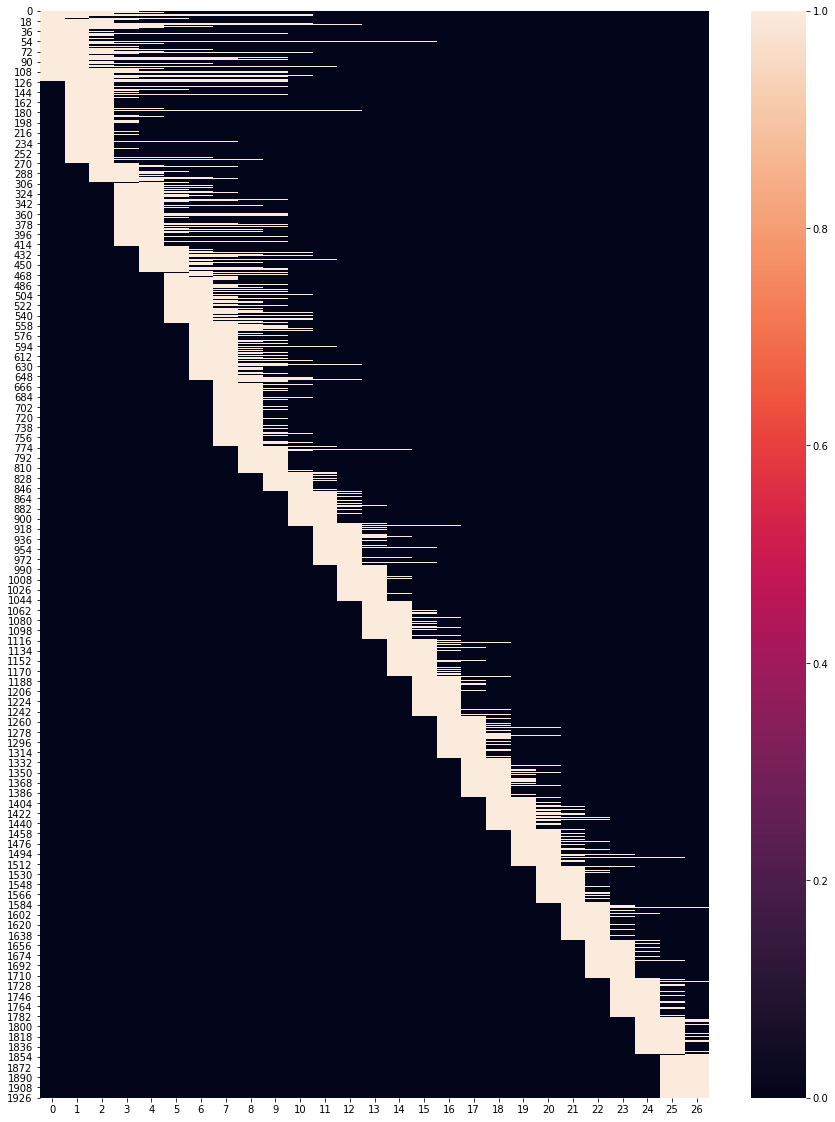

In [7]:
plt.figure(figsize=(15, 20))
sns.heatmap(np.where(global_matches > 0, 1, 0));

In [8]:
W = np.identity(2)

K = np.array([[1.23472227e+03, 0.00000000e+00, 6.38814655e+02],
              [0.00000000e+00, 1.23122213e+03, 3.37257425e+02],
              [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

camera_k = np.array([K[0, 0],
                     K[1, 1],
                     K[0, 2],
                     K[1, 2]])

marker_size = 0.144

marker_points = np.array([[-marker_size / 2, -marker_size / 2, 0],
                          [ marker_size / 2, -marker_size / 2, 0],
                          [ marker_size / 2,  marker_size / 2, 0],
                          [-marker_size / 2,  marker_size / 2, 0]])

In [9]:
mrob.RANSAC?

Type:           FGraph.robustFactorType
String form:    FGraph.robustFactorType.RANSAC
File:           c:\users\almam\anaconda3\lib\site-packages\mrob\pybind.cp38-win_amd64.pyd
Docstring:     
Members:

QUADRATIC

CAUCHY

HUBER

MCCLURE

RANSAC
Init docstring: __init__(self: mrob.pybind.FGraph.robustFactorType, value: int) -> None


In [10]:
graph = mrob.FGraph()

In [11]:
graph.add_factor_1pose_3d?

Docstring: add_factor_1pose_3d(self: mrob.pybind.FGraph, arg0: mrob.pybind.geometry.SE3, arg1: int, arg2: numpy.ndarray[numpy.float64[6, 6]]) -> int
Type:      method


In [12]:
graph = mrob.FGraph(mrob.CAUCHY)

global_matches_to_graph_id = {}
corners_to_graph_id = {}

poses_indeces_in_graph = []
last_position = np.zeros((3, 1))

for angle in range(4):
    l = graph.add_node_landmark_3d(marker_points[angle], mrob.NODE_ANCHOR)
    corners_to_graph_id[angle] = l

for kf in tqdm(range(len(keyframes))):
# for kf in tqdm(range(len(detected_arucos))):

    if len(detected_arucos) > kf:
        # pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]))

        pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

        # graph.add_factor_1pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]), pose_id, np.linalg.inv(np.diag((0.1, 0.1, 0.1, 0.5, 0.5, 0.5))))
        graph.add_factor_1pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]), pose_id, np.diag((0.1, 0.1, 0.1, 0.4, 0.4, 0.4)))

        for angles in range(4):
            graph.add_factor_camera_proj_3d_point(
                obs = detected_arucos[kf][2][angle],
                nodePoseId = pose_id,
                nodeLandmarkId = corners_to_graph_id[angle],
                camera_k = camera_k,
                obsInvCov = W)

    # if kf == 0:
    #     pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(), mrob.NODE_ANCHOR)
    else:
        pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(last_pose))
        # pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

    poses_indeces_in_graph.append(pose_id)
    
    for global_match_index in range(global_matches.shape[0]):

        if global_matches[global_match_index, kf] == -1:
            continue
        
        if not (global_match_index in global_matches_to_graph_id.keys()):
            l = graph.add_node_landmark_3d(last_position + 10*np.random.random((3, 1)))
            # l = graph.add_node_landmark_3d(np.random.random((3, 1)))
            global_matches_to_graph_id[global_match_index] = l
            
        graph.add_factor_camera_proj_3d_point(
                obs = keyframes[kf][1][global_matches[global_match_index, kf]].pt,
                nodePoseId = pose_id,
                nodeLandmarkId = global_matches_to_graph_id[global_match_index],
                camera_k = camera_k,
                obsInvCov = W)
    
    # print(f"{kf} : {graph.solve(method=mrob.LM, maxIters=200)} iterations")
    graph.solve(method=mrob.LM)
    last_pose = graph.get_estimated_state()[pose_id]
    last_position = last_pose[0:3, 3:]
    
print(graph.chi2())

100%|██████████| 27/27 [00:13<00:00,  1.95it/s]

15372021149.57401


In [13]:
landmarks_3d = np.array([x for x in np.array(graph.get_estimated_state())[list(global_matches_to_graph_id.values())]]).reshape(-1, 3)
camera_poses = np.array([x for x in np.array(graph.get_estimated_state())[poses_indeces_in_graph]])

<ipython-input-13-12efa0be8e6e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  landmarks_3d = np.array([x for x in np.array(graph.get_estimated_state())[list(global_matches_to_graph_id.values())]]).reshape(-1, 3)
<ipython-input-13-12efa0be8e6e>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  camera_poses = np.array([x for x in np.array(graph.get_estimated_state())[poses_indeces_in_graph]])


In [38]:
def plot_data(poses, landmarks, marker_points, arrows_length=0.05):

    positions = []
    orientations = []

    for i in range(len(poses)):
        positions.append(poses[i][:3, 3])
        orientations.append(poses[i][:3, :3])

    positions = np.array(positions)

    x_unit = np.array([[1],[0],[0]]) * arrows_length
    y_unit = np.array([[0],[1],[0]]) * arrows_length
    z_unit = np.array([[0],[0],[1]]) * arrows_length

    x_ends = []
    y_ends = []
    z_ends = []

    for i in range(len(orientations)):
        x_ends.append(orientations[i] @ x_unit)
        y_ends.append(orientations[i] @ y_unit)
        z_ends.append(orientations[i] @ z_unit)

    layout = go.Layout(scene=dict(aspectmode='data'))

    arrows = []

    for i in range(len(x_ends)):
        arrows.append(go.Scatter3d(x=[positions[i][0], positions[i][0] + x_ends[i][0][0]],
                                   y=[positions[i][1], positions[i][1] + x_ends[i][1][0]],
                                   z=[positions[i][2], positions[i][2] + x_ends[i][2][0]],
                                   marker_size=1, line=dict(color='red',width=2)))

    for i in range(len(y_ends)):
        arrows.append(go.Scatter3d(x=[positions[i][0], positions[i][0] + y_ends[i][0][0]],
                                   y=[positions[i][1], positions[i][1] + y_ends[i][1][0]],
                                   z=[positions[i][2], positions[i][2] + y_ends[i][2][0]],
                                   marker_size=1, line=dict(color='green',width=2)))

    for i in range(len(z_ends)):
        arrows.append(go.Scatter3d(x=[positions[i][0], positions[i][0] + z_ends[i][0][0]],
                                   y=[positions[i][1], positions[i][1] + z_ends[i][1][0]],
                                   z=[positions[i][2], positions[i][2] + z_ends[i][2][0]],
                                   marker_size=1, line=dict(color='blue',width=2)))

    fig = go.Figure(data=[go.Scatter3d(x=positions.T[0],
                                       y=positions.T[1],
                                       z=positions.T[2],
                                       marker_size=3,
                                       text=np.arange(0, len(positions)),
                                       line=dict(color='black',width=2))] + \
                         [go.Scatter3d(x=landmarks.T[0],
                                       y=landmarks.T[1],
                                       z=landmarks.T[2],
                                       mode='markers',
                                       marker=dict(color='blue', size=1))] + \
                         [go.Scatter3d(x=marker_points.T[0],
                                       y=marker_points.T[1],
                                       z=marker_points.T[2],
                                       mode='markers',
                                       marker=dict(color='orange', size=3))] + \
                        arrows,
                        layout=layout)

    fig.show()

In [39]:
plot_data(camera_poses, landmarks_3d, marker_points)

In [19]:
fig = go.Figure(data=[go.Scatter3d(x=landmarks_3d[0], y=landmarks_3d[1], z=landmarks_3d[2],
                                   mode='markers', marker_size=1)] + 
                     [go.Scatter3d(x=marker_points.T[0], y=marker_points.T[1], z=marker_points.T[2],
                                   mode='markers', marker_size=3)] + 
                     [go.Scatter3d(x=camera_poses[0], y=camera_poses[1], z=camera_poses[2],
                                   line=dict(color='darkblue',width=2), marker_size=3, text=np.arange(0, len(keyframes)))])

window = 3
width = np.max(camera_poses, axis=1) - np.min(camera_poses, axis=1)
range_ = np.vstack((np.mean(camera_poses, axis=1) - window * width, np.mean(camera_poses, axis=1) + window * width))

range_ = range_.T

fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=range_[0]),
        yaxis = dict(nticks=4, range=range_[1]),
        zaxis = dict(nticks=4, range=range_[2]),
        aspectmode='data'))

fig.show()
# fig.write_html("feature_map.html")

In [24]:
# fig.write_html("G.html")

In [83]:
# U, S, V = np.linalg.svd(camera_poses)
# S[2] = 0
# projected_points = U[:2, :] @ np.diag(S[:]) @ V.T[:3, :]

# plt.figure(figsize=(15, 10))
# plt.scatter(projected_points[0], projected_points[1], )
# plt.plot(projected_points[0], projected_points[1])
# for i in range(projected_points.shape[1]):
#     plt.annotate(i, (projected_points[0][i], projected_points[1][i]))
# plt.show()

In [57]:
window = 2
width = np.max(camera_poses, axis=1) - np.min(camera_poses, axis=1)
range_ = np.vstack((np.mean(camera_poses, axis=1) - window * width, np.mean(camera_poses, axis=1) + window * width))

range_ = range_.T
range_

array([[-0.50691447,  0.27897698],
       [-0.4858643 ,  0.54334957],
       [-4.73437764,  2.12785714]])

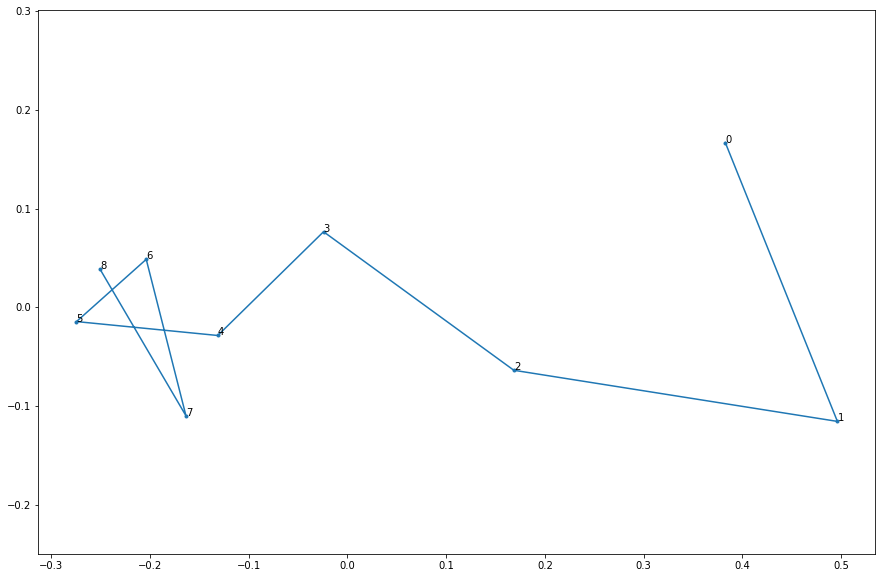

In [47]:
pca = PCA(n_components=2)
proj_points = pca.fit_transform(camera_poses.T)
proj_points = proj_points.T

plt.figure(figsize=(15, 10))
plt.axis('equal')
plt.plot(proj_points[0], proj_points[1], marker='.')
for i in range(proj_points.shape[1]):
    plt.annotate(i, (proj_points[0][i], proj_points[1][i]))
plt.show()

In [ ]:
# global_matches = []

# for m in range(len(keyframes[1][3])):
#     global_matches.append([keyframes[1][3][m].queryIdx, keyframes[1][3][m].trainIdx])

# for kf in tqdm(range(2, len(keyframes))):
#     for m in range(len(keyframes[kf][3])):
#         found_match = False
#         for global_match in global_matches:
#             if global_match[-1] == keyframes[kf][3][m].queryIdx and len(global_match) != kf+1:
#                 global_match.append(keyframes[kf][3][m].trainIdx)
#                 found_match = True
#         if not found_match:
#             global_matches.append([-1] * (kf - 1) + [keyframes[kf][3][m].queryIdx, keyframes[kf][3][m].trainIdx])
            
#     for global_match in global_matches:
#         if len(global_match) < kf + 1:
#             global_match.extend([-1])

# assert len(keyframes) == min([len(x) for x in global_matches]) == max([len(x) for x in global_matches])

# global_matches = []

# for kf_1 in tqdm(range(len(keyframes))):
    
#     kp_1, des_1 = orb.detectAndCompute(keyframes[kf_1][2], None)

#     for kf_2 in range(kf_1 + 1, len(keyframes)):
#         kp_2, des_2 = orb.detectAndCompute(keyframes[kf_2][2], None)
#         matches = bf.knnMatch(des_1, des_2, k=2)

#         for m,n in keyframe_matches:
#             if m.distance < 0.75*n.distance:
#                 good.append(m)
            
#         for m in good:


In [94]:
for iteration in range(30):
    graph = mrob.FGraph(mrob.CAUCHY)

    global_matches_to_graph_id = {}
    corners_to_graph_id = {}

    poses_indeces_in_graph = []
    last_position = np.zeros((3, 1))

    for angle in range(4):
        l = graph.add_node_landmark_3d(marker_points[angle], mrob.NODE_ANCHOR)
        corners_to_graph_id[angle] = l

    for kf in tqdm(range(len(keyframes))):
    # for kf in tqdm(range(len(detected_arucos))):

        if len(detected_arucos) > kf:
            # pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]))

            pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

            graph.add_factor_1pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]), pose_id, np.linalg.inv(np.diag((0.1, 0.1, 0.1, 0.5, 0.5, 0.5))))
            # graph.add_factor_1pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]), pose_id, np.diag((0.1, 0.1, 0.1, 0.5, 0.5, 0.5)))

            for angles in range(4):
                graph.add_factor_camera_proj_3d_point(
                    obs = detected_arucos[kf][2][angle],
                    nodePoseId = pose_id,
                    nodeLandmarkId = corners_to_graph_id[angle],
                    camera_k = camera_k,
                    obsInvCov = W)

        # if kf == 0:
        #     pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(), mrob.NODE_ANCHOR)
        else:
            pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(last_pose))
            # pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

        poses_indeces_in_graph.append(pose_id)
        
        for global_match_index in range(global_matches.shape[0]):

            if global_matches[global_match_index, kf] == -1:
                continue
            
            if not (global_match_index in global_matches_to_graph_id.keys()):
                l = graph.add_node_landmark_3d(last_position + np.random.random((3, 1)))
                # l = graph.add_node_landmark_3d(np.random.random((3, 1)))
                global_matches_to_graph_id[global_match_index] = l
                
            graph.add_factor_camera_proj_3d_point(
                    obs = keyframes[kf][1][global_matches[global_match_index, kf]].pt,
                    nodePoseId = pose_id,
                    nodeLandmarkId = global_matches_to_graph_id[global_match_index],
                    camera_k = camera_k,
                    obsInvCov = W)
        
        # print(f"{kf} : {graph.solve(method=mrob.LM, maxIters=200)} iterations")
        graph.solve(method=mrob.LM, maxIters=200)
        last_pose = graph.get_estimated_state()[pose_id]
        last_position = last_pose[0:3, 3:]
        
    print(graph.chi2())

    landmarks_3d = np.array([x for x in np.array(graph.get_estimated_state())[list(global_matches_to_graph_id.values())]]).reshape(-1, 3).T
    camera_poses = np.array([x[0:3, 3] for x in np.array(graph.get_estimated_state())[poses_indeces_in_graph]]).T

    fig = go.Figure(data=[go.Scatter3d(x=landmarks_3d[0], y=landmarks_3d[1], z=landmarks_3d[2],
                                   mode='markers', marker_size=1)] + 
                     [go.Scatter3d(x=marker_points.T[0], y=marker_points.T[1], z=marker_points.T[2],
                                   mode='markers', marker_size=3)] + 
                     [go.Scatter3d(x=camera_poses[0], y=camera_poses[1], z=camera_poses[2],
                                   line=dict(color='darkblue',width=2), marker_size=3, text=np.arange(0, len(keyframes)))])

    window = 3
    width = np.max(camera_poses, axis=1) - np.min(camera_poses, axis=1)
    range_ = np.vstack((np.mean(camera_poses, axis=1) - window * width, np.mean(camera_poses, axis=1) + window * width))

    range_ = range_.T

    fig.update_layout(
        scene = dict(
            xaxis = dict(nticks=4, range=range_[0]),
            yaxis = dict(nticks=4, range=range_[1]),
            zaxis = dict(nticks=4, range=range_[2]),
            aspectmode='data'))

    # fig.show()
    fig.write_html(f"./maps/map_{iteration}.html")


for iteration in range(30, 60):
    graph = mrob.FGraph(mrob.MCCLURE)

    global_matches_to_graph_id = {}
    corners_to_graph_id = {}

    poses_indeces_in_graph = []
    last_position = np.zeros((3, 1))

    for angle in range(4):
        l = graph.add_node_landmark_3d(marker_points[angle], mrob.NODE_ANCHOR)
        corners_to_graph_id[angle] = l

    for kf in tqdm(range(len(keyframes))):
    # for kf in tqdm(range(len(detected_arucos))):

        if len(detected_arucos) > kf:
            # pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]))

            pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

            graph.add_factor_1pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]), pose_id, np.linalg.inv(np.diag((0.1, 0.1, 0.1, 0.5, 0.5, 0.5))))
            # graph.add_factor_1pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]), pose_id, np.diag((0.1, 0.1, 0.1, 0.5, 0.5, 0.5)))

            for angles in range(4):
                graph.add_factor_camera_proj_3d_point(
                    obs = detected_arucos[kf][2][angle],
                    nodePoseId = pose_id,
                    nodeLandmarkId = corners_to_graph_id[angle],
                    camera_k = camera_k,
                    obsInvCov = W)

        # if kf == 0:
        #     pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(), mrob.NODE_ANCHOR)
        else:
            pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(last_pose))
            # pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

        poses_indeces_in_graph.append(pose_id)
        
        for global_match_index in range(global_matches.shape[0]):

            if global_matches[global_match_index, kf] == -1:
                continue
            
            if not (global_match_index in global_matches_to_graph_id.keys()):
                l = graph.add_node_landmark_3d(last_position + np.random.random((3, 1)))
                # l = graph.add_node_landmark_3d(np.random.random((3, 1)))
                global_matches_to_graph_id[global_match_index] = l
                
            graph.add_factor_camera_proj_3d_point(
                    obs = keyframes[kf][1][global_matches[global_match_index, kf]].pt,
                    nodePoseId = pose_id,
                    nodeLandmarkId = global_matches_to_graph_id[global_match_index],
                    camera_k = camera_k,
                    obsInvCov = W)
        
        # print(f"{kf} : {graph.solve(method=mrob.LM, maxIters=200)} iterations")
        graph.solve(method=mrob.LM, maxIters=200)
        last_pose = graph.get_estimated_state()[pose_id]
        last_position = last_pose[0:3, 3:]
        
    print(graph.chi2())

    landmarks_3d = np.array([x for x in np.array(graph.get_estimated_state())[list(global_matches_to_graph_id.values())]]).reshape(-1, 3).T
    camera_poses = np.array([x[0:3, 3] for x in np.array(graph.get_estimated_state())[poses_indeces_in_graph]]).T

    fig = go.Figure(data=[go.Scatter3d(x=landmarks_3d[0], y=landmarks_3d[1], z=landmarks_3d[2],
                                   mode='markers', marker_size=1)] + 
                     [go.Scatter3d(x=marker_points.T[0], y=marker_points.T[1], z=marker_points.T[2],
                                   mode='markers', marker_size=3)] + 
                     [go.Scatter3d(x=camera_poses[0], y=camera_poses[1], z=camera_poses[2],
                                   line=dict(color='darkblue',width=2), marker_size=3, text=np.arange(0, len(keyframes)))])

    window = 3
    width = np.max(camera_poses, axis=1) - np.min(camera_poses, axis=1)
    range_ = np.vstack((np.mean(camera_poses, axis=1) - window * width, np.mean(camera_poses, axis=1) + window * width))

    range_ = range_.T

    fig.update_layout(
        scene = dict(
            xaxis = dict(nticks=4, range=range_[0]),
            yaxis = dict(nticks=4, range=range_[1]),
            zaxis = dict(nticks=4, range=range_[2]),
            aspectmode='data'))

    # fig.show()
    fig.write_html(f"./maps/map_{iteration}.html")

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [01:02<00:00,  2.32s/it]
<ipython-input-94-b88d4f637b74>:65: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

<ipython-input-94-b88d4f637b74>:66: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



3411620250.886453


100%|██████████| 27/27 [01:38<00:00,  3.67s/it]


62468526025.46844


100%|██████████| 27/27 [01:18<00:00,  2.92s/it]


292793155.921304


100%|██████████| 27/27 [00:55<00:00,  2.07s/it]


438252148.2029253


100%|██████████| 27/27 [01:05<00:00,  2.43s/it]


554780668.8344271


100%|██████████| 27/27 [01:07<00:00,  2.48s/it]


513922733.2204293


100%|██████████| 27/27 [01:06<00:00,  2.48s/it]


388052436.14505666


100%|██████████| 27/27 [01:14<00:00,  2.74s/it]


3190664699.78875


100%|██████████| 27/27 [01:16<00:00,  2.84s/it]


7478940987.784977


100%|██████████| 27/27 [01:00<00:00,  2.25s/it]


2168610749.0009093


100%|██████████| 27/27 [00:58<00:00,  2.18s/it]


351744818.3747611


100%|██████████| 27/27 [01:02<00:00,  2.32s/it]


2344731173.328132


100%|██████████| 27/27 [01:05<00:00,  2.44s/it]


552903150.4251729


100%|██████████| 27/27 [01:03<00:00,  2.36s/it]


354586147.5214544


100%|██████████| 27/27 [01:25<00:00,  3.17s/it]


24603652470.486343


100%|██████████| 27/27 [01:02<00:00,  2.32s/it]


1197796946.8105555


100%|██████████| 27/27 [00:55<00:00,  2.07s/it]


655855038.8377161


100%|██████████| 27/27 [01:15<00:00,  2.80s/it]


103619405550.83597


100%|██████████| 27/27 [00:52<00:00,  1.93s/it]


2539440937.1068287


100%|██████████| 27/27 [00:48<00:00,  1.81s/it]


384383901.41255873


100%|██████████| 27/27 [01:01<00:00,  2.28s/it]


593623401.8779016


100%|██████████| 27/27 [01:11<00:00,  2.64s/it]


94791545367.35942


100%|██████████| 27/27 [01:07<00:00,  2.51s/it]


729336030.8076675


100%|██████████| 27/27 [01:00<00:00,  2.25s/it]


1690046254.912068


100%|██████████| 27/27 [00:52<00:00,  1.96s/it]


744836486.1120456


100%|██████████| 27/27 [00:59<00:00,  2.21s/it]


355839356.77038395


100%|██████████| 27/27 [00:49<00:00,  1.83s/it]


392123480.31073666


100%|██████████| 27/27 [00:55<00:00,  2.05s/it]


3185332874.7755866


100%|██████████| 27/27 [01:10<00:00,  2.61s/it]


12475165689.498598


100%|██████████| 27/27 [01:09<00:00,  2.56s/it]


1776811586.3953857


100%|██████████| 27/27 [01:17<00:00,  2.87s/it]
<ipython-input-94-b88d4f637b74>:156: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

<ipython-input-94-b88d4f637b74>:157: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



37214828146.23583


100%|██████████| 27/27 [01:00<00:00,  2.22s/it]


173418102096.39948


100%|██████████| 27/27 [00:43<00:00,  1.62s/it]


49427876741.17151


100%|██████████| 27/27 [00:44<00:00,  1.65s/it]


5458480695.768927


100%|██████████| 27/27 [01:02<00:00,  2.32s/it]


129614337462.08975


100%|██████████| 27/27 [00:59<00:00,  2.22s/it]


33622713878.900505


100%|██████████| 27/27 [01:18<00:00,  2.90s/it]


130035299967.27563


100%|██████████| 27/27 [00:58<00:00,  2.18s/it]


163079949284.24445


100%|██████████| 27/27 [00:53<00:00,  1.96s/it]


5907490354.082194


100%|██████████| 27/27 [01:01<00:00,  2.29s/it]


1199925150.2547936


100%|██████████| 27/27 [01:00<00:00,  2.25s/it]


24825991627.086533


100%|██████████| 27/27 [00:34<00:00,  1.28s/it]


115770972252.07158


100%|██████████| 27/27 [01:11<00:00,  2.64s/it]


25706120399.94656


100%|██████████| 27/27 [00:48<00:00,  1.80s/it]


35685955631.39125


100%|██████████| 27/27 [01:14<00:00,  2.76s/it]


41277089078.895256


100%|██████████| 27/27 [00:39<00:00,  1.45s/it]


33078132166.591534


100%|██████████| 27/27 [00:57<00:00,  2.14s/it]


94023894274.95876


100%|██████████| 27/27 [00:52<00:00,  1.94s/it]


5224994641.045611


100%|██████████| 27/27 [00:40<00:00,  1.49s/it]


187575980564.98618


100%|██████████| 27/27 [00:42<00:00,  1.58s/it]


166431541902.71844


100%|██████████| 27/27 [01:11<00:00,  2.63s/it]


87538717628.83061


100%|██████████| 27/27 [00:57<00:00,  2.11s/it]


324941654872.5728


100%|██████████| 27/27 [01:20<00:00,  2.99s/it]


10634350278.515049


100%|██████████| 27/27 [01:20<00:00,  2.99s/it]


62142085400.10733


100%|██████████| 27/27 [01:42<00:00,  3.78s/it]


228418381867.51443


100%|██████████| 27/27 [00:55<00:00,  2.05s/it]


10107906770.443985


100%|██████████| 27/27 [00:59<00:00,  2.21s/it]


29989543770.420998


100%|██████████| 27/27 [00:52<00:00,  1.95s/it]


25945734856.731606


100%|██████████| 27/27 [00:42<00:00,  1.56s/it]


1271191988.7584443


100%|██████████| 27/27 [01:02<00:00,  2.30s/it]

70811532490.86316


In [95]:
for iteration in range(30):
    graph = mrob.FGraph(mrob.CAUCHY)

    global_matches_to_graph_id = {}
    corners_to_graph_id = {}

    poses_indeces_in_graph = []
    last_position = np.zeros((3, 1))

    for angle in range(4):
        l = graph.add_node_landmark_3d(marker_points[angle], mrob.NODE_ANCHOR)
        corners_to_graph_id[angle] = l

    for kf in tqdm(range(len(keyframes))):
    # for kf in tqdm(range(len(detected_arucos))):

        if len(detected_arucos) > kf:
            # pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]))

            pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

            graph.add_factor_1pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]), pose_id, np.linalg.inv(np.diag((0.1, 0.1, 0.1, 0.5, 0.5, 0.5))))
            # graph.add_factor_1pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]), pose_id, np.diag((0.1, 0.1, 0.1, 0.5, 0.5, 0.5)))

            for angles in range(4):
                graph.add_factor_camera_proj_3d_point(
                    obs = detected_arucos[kf][2][angle],
                    nodePoseId = pose_id,
                    nodeLandmarkId = corners_to_graph_id[angle],
                    camera_k = camera_k,
                    obsInvCov = W)

        # if kf == 0:
        #     pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(), mrob.NODE_ANCHOR)
        else:
            pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(last_pose))
            # pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

        poses_indeces_in_graph.append(pose_id)
        
        for global_match_index in range(global_matches.shape[0]):

            if global_matches[global_match_index, kf] == -1:
                continue
            
            if not (global_match_index in global_matches_to_graph_id.keys()):
                l = graph.add_node_landmark_3d(last_position + np.random.random((3, 1)))
                # l = graph.add_node_landmark_3d(np.random.random((3, 1)))
                global_matches_to_graph_id[global_match_index] = l
                
            graph.add_factor_camera_proj_3d_point(
                    obs = keyframes[kf][1][global_matches[global_match_index, kf]].pt,
                    nodePoseId = pose_id,
                    nodeLandmarkId = global_matches_to_graph_id[global_match_index],
                    camera_k = camera_k,
                    obsInvCov = W)
        
        # print(f"{kf} : {graph.solve(method=mrob.LM, maxIters=200)} iterations")
        graph.solve(method=mrob.LM, maxIters=200)
        last_pose = graph.get_estimated_state()[pose_id]
        last_position = last_pose[0:3, 3:]
        
    print(graph.chi2())

    landmarks_3d = np.array([x for x in np.array(graph.get_estimated_state())[list(global_matches_to_graph_id.values())]]).reshape(-1, 3).T
    camera_poses = np.array([x[0:3, 3] for x in np.array(graph.get_estimated_state())[poses_indeces_in_graph]]).T

    fig = go.Figure(data=[go.Scatter3d(x=landmarks_3d[0], y=landmarks_3d[1], z=landmarks_3d[2],
                                   mode='markers', marker_size=1)] + 
                     [go.Scatter3d(x=marker_points.T[0], y=marker_points.T[1], z=marker_points.T[2],
                                   mode='markers', marker_size=3)] + 
                     [go.Scatter3d(x=camera_poses[0], y=camera_poses[1], z=camera_poses[2],
                                   line=dict(color='darkblue',width=2), marker_size=3, text=np.arange(0, len(keyframes)))])

    window = 3
    width = np.max(camera_poses, axis=1) - np.min(camera_poses, axis=1)
    range_ = np.vstack((np.mean(camera_poses, axis=1) - window * width, np.mean(camera_poses, axis=1) + window * width))

    range_ = range_.T

    fig.update_layout(
        scene = dict(
            xaxis = dict(nticks=4, range=range_[0]),
            yaxis = dict(nticks=4, range=range_[1]),
            zaxis = dict(nticks=4, range=range_[2]),
            aspectmode='data'))

    # fig.show()
    fig.write_html(f"./maps_table/map_{iteration}.html")


for iteration in range(30, 60):
    graph = mrob.FGraph(mrob.MCCLURE)

    global_matches_to_graph_id = {}
    corners_to_graph_id = {}

    poses_indeces_in_graph = []
    last_position = np.zeros((3, 1))

    for angle in range(4):
        l = graph.add_node_landmark_3d(marker_points[angle], mrob.NODE_ANCHOR)
        corners_to_graph_id[angle] = l

    for kf in tqdm(range(len(keyframes))):
    # for kf in tqdm(range(len(detected_arucos))):

        if len(detected_arucos) > kf:
            # pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]))

            pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

            graph.add_factor_1pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]), pose_id, np.linalg.inv(np.diag((0.1, 0.1, 0.1, 0.5, 0.5, 0.5))))
            # graph.add_factor_1pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]), pose_id, np.diag((0.1, 0.1, 0.1, 0.5, 0.5, 0.5)))

            for angles in range(4):
                graph.add_factor_camera_proj_3d_point(
                    obs = detected_arucos[kf][2][angle],
                    nodePoseId = pose_id,
                    nodeLandmarkId = corners_to_graph_id[angle],
                    camera_k = camera_k,
                    obsInvCov = W)

        # if kf == 0:
        #     pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(), mrob.NODE_ANCHOR)
        else:
            pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(last_pose))
            # pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

        poses_indeces_in_graph.append(pose_id)
        
        for global_match_index in range(global_matches.shape[0]):

            if global_matches[global_match_index, kf] == -1:
                continue
            
            if not (global_match_index in global_matches_to_graph_id.keys()):
                l = graph.add_node_landmark_3d(last_position + np.random.random((3, 1)))
                # l = graph.add_node_landmark_3d(np.random.random((3, 1)))
                global_matches_to_graph_id[global_match_index] = l
                
            graph.add_factor_camera_proj_3d_point(
                    obs = keyframes[kf][1][global_matches[global_match_index, kf]].pt,
                    nodePoseId = pose_id,
                    nodeLandmarkId = global_matches_to_graph_id[global_match_index],
                    camera_k = camera_k,
                    obsInvCov = W)
        
        # print(f"{kf} : {graph.solve(method=mrob.LM, maxIters=200)} iterations")
        graph.solve(method=mrob.LM, maxIters=200)
        last_pose = graph.get_estimated_state()[pose_id]
        last_position = last_pose[0:3, 3:]
        
    print(graph.chi2())

    landmarks_3d = np.array([x for x in np.array(graph.get_estimated_state())[list(global_matches_to_graph_id.values())]]).reshape(-1, 3).T
    camera_poses = np.array([x[0:3, 3] for x in np.array(graph.get_estimated_state())[poses_indeces_in_graph]]).T

    fig = go.Figure(data=[go.Scatter3d(x=landmarks_3d[0], y=landmarks_3d[1], z=landmarks_3d[2],
                                   mode='markers', marker_size=1)] + 
                     [go.Scatter3d(x=marker_points.T[0], y=marker_points.T[1], z=marker_points.T[2],
                                   mode='markers', marker_size=3)] + 
                     [go.Scatter3d(x=camera_poses[0], y=camera_poses[1], z=camera_poses[2],
                                   line=dict(color='darkblue',width=2), marker_size=3, text=np.arange(0, len(keyframes)))])

    window = 3
    width = np.max(camera_poses, axis=1) - np.min(camera_poses, axis=1)
    range_ = np.vstack((np.mean(camera_poses, axis=1) - window * width, np.mean(camera_poses, axis=1) + window * width))

    range_ = range_.T

    fig.update_layout(
        scene = dict(
            xaxis = dict(nticks=4, range=range_[0]),
            yaxis = dict(nticks=4, range=range_[1]),
            zaxis = dict(nticks=4, range=range_[2]),
            aspectmode='data'))

    # fig.show()
    fig.write_html(f"./maps_table/map_{iteration}.html")

100%|██████████| 27/27 [01:02<00:00,  2.33s/it]
<ipython-input-95-dc29b7da4c84>:65: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

<ipython-input-95-dc29b7da4c84>:66: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



357512166.80045193


100%|██████████| 27/27 [01:35<00:00,  3.53s/it]


103178772738.42142


100%|██████████| 27/27 [00:53<00:00,  2.00s/it]


2624756634.4634995


100%|██████████| 27/27 [01:39<00:00,  3.70s/it]


255068206857.43893


100%|██████████| 27/27 [01:10<00:00,  2.62s/it]


41176144659.27158


100%|██████████| 27/27 [01:07<00:00,  2.50s/it]


336017166.24703985


100%|██████████| 27/27 [01:26<00:00,  3.21s/it]


797190606.1845068


100%|██████████| 27/27 [01:28<00:00,  3.27s/it]


25523053206.289955


100%|██████████| 27/27 [01:19<00:00,  2.94s/it]


461833994.83893174


100%|██████████| 27/27 [01:33<00:00,  3.45s/it]


9300779335.317924


100%|██████████| 27/27 [01:17<00:00,  2.88s/it]


11925617789.675829


100%|██████████| 27/27 [01:08<00:00,  2.55s/it]


10196290940.258564


100%|██████████| 27/27 [01:03<00:00,  2.34s/it]


10665985805.11636


100%|██████████| 27/27 [01:08<00:00,  2.53s/it]


906314887.0451293


100%|██████████| 27/27 [01:02<00:00,  2.30s/it]


6613514671.850998


100%|██████████| 27/27 [01:15<00:00,  2.81s/it]


51506832497.36449


100%|██████████| 27/27 [01:16<00:00,  2.82s/it]


783577003.574699


100%|██████████| 27/27 [01:05<00:00,  2.44s/it]


1110775671.5640872


100%|██████████| 27/27 [01:17<00:00,  2.88s/it]


543552051373.89575


100%|██████████| 27/27 [01:06<00:00,  2.46s/it]


1390330913.2822783


100%|██████████| 27/27 [01:27<00:00,  3.24s/it]


38796488013.68242


100%|██████████| 27/27 [00:53<00:00,  1.99s/it]


10997140399.016653


100%|██████████| 27/27 [01:01<00:00,  2.27s/it]


377670072.39973825


100%|██████████| 27/27 [01:08<00:00,  2.55s/it]


505588011.1708051


100%|██████████| 27/27 [01:11<00:00,  2.66s/it]


51822486191.935135


100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


4545251443.469125


100%|██████████| 27/27 [01:15<00:00,  2.81s/it]


27847032968.387978


100%|██████████| 27/27 [01:01<00:00,  2.29s/it]


341157006.4247528


100%|██████████| 27/27 [00:57<00:00,  2.14s/it]


262535349.48857167


100%|██████████| 27/27 [01:30<00:00,  3.34s/it]


88156020884.67691


100%|██████████| 27/27 [01:36<00:00,  3.57s/it]
<ipython-input-95-dc29b7da4c84>:156: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

<ipython-input-95-dc29b7da4c84>:157: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



119311826788.80595


100%|██████████| 27/27 [01:30<00:00,  3.36s/it]


6195786633.365019


100%|██████████| 27/27 [00:42<00:00,  1.59s/it]


39543826251.78971


100%|██████████| 27/27 [00:37<00:00,  1.39s/it]


64632608228.751335


100%|██████████| 27/27 [01:24<00:00,  3.14s/it]


467598471708.903


100%|██████████| 27/27 [00:48<00:00,  1.80s/it]


69153964002.79054


100%|██████████| 27/27 [00:42<00:00,  1.58s/it]


25196936480.155125


100%|██████████| 27/27 [01:44<00:00,  3.86s/it]


322865244136.1005


100%|██████████| 27/27 [01:09<00:00,  2.57s/it]


18117797454.56458


100%|██████████| 27/27 [01:44<00:00,  3.89s/it]


16448646704.741714


100%|██████████| 27/27 [01:02<00:00,  2.30s/it]


945817612.9016533


100%|██████████| 27/27 [00:54<00:00,  2.01s/it]


30349900102.14201


100%|██████████| 27/27 [01:42<00:00,  3.78s/it]


247927773316.0858


100%|██████████| 27/27 [00:44<00:00,  1.67s/it]


65297704538.3282


100%|██████████| 27/27 [01:46<00:00,  3.95s/it]


136637028772.99689


100%|██████████| 27/27 [01:09<00:00,  2.56s/it]


3706884225.6696134


100%|██████████| 27/27 [01:22<00:00,  3.04s/it]


887600368444.2946


100%|██████████| 27/27 [01:05<00:00,  2.44s/it]


198850035155.05557


100%|██████████| 27/27 [01:15<00:00,  2.80s/it]


14142316056.825829


100%|██████████| 27/27 [01:39<00:00,  3.69s/it]


33726711300.16296


100%|██████████| 27/27 [01:05<00:00,  2.44s/it]


11414543383.6271


100%|██████████| 27/27 [01:01<00:00,  2.30s/it]


1638961956.6507442


100%|██████████| 27/27 [01:08<00:00,  2.52s/it]


17738509119.97908


100%|██████████| 27/27 [00:55<00:00,  2.04s/it]


119162545.6677074


100%|██████████| 27/27 [00:39<00:00,  1.46s/it]


95530199349.88266


100%|██████████| 27/27 [00:44<00:00,  1.65s/it]


197299230175.53897


100%|██████████| 27/27 [01:36<00:00,  3.58s/it]


1272784060659.093


100%|██████████| 27/27 [01:36<00:00,  3.57s/it]


121487294163.18346


100%|██████████| 27/27 [00:43<00:00,  1.62s/it]


18621771169.677372


100%|██████████| 27/27 [01:07<00:00,  2.51s/it]

18777699182.72722


In [ ]:
for iteration in range(30):
    graph = mrob.FGraph(mrob.CAUCHY)

    global_matches_to_graph_id = {}
    corners_to_graph_id = {}

    poses_indeces_in_graph = []
    last_position = np.zeros((3, 1))

    for angle in range(4):
        l = graph.add_node_landmark_3d(marker_points[angle], mrob.NODE_ANCHOR)
        corners_to_graph_id[angle] = l

    for kf in tqdm(range(len(keyframes))):
    # for kf in tqdm(range(len(detected_arucos))):

        if len(detected_arucos) > kf:
            # pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]))

            pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

            graph.add_factor_1pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]), pose_id, np.linalg.inv(np.diag((0.1, 0.1, 0.1, 0.5, 0.5, 0.5))))
            # graph.add_factor_1pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]), pose_id, np.diag((0.1, 0.1, 0.1, 0.5, 0.5, 0.5)))

            for angles in range(4):
                graph.add_factor_camera_proj_3d_point(
                    obs = detected_arucos[kf][2][angle],
                    nodePoseId = pose_id,
                    nodeLandmarkId = corners_to_graph_id[angle],
                    camera_k = camera_k,
                    obsInvCov = W)

        # if kf == 0:
        #     pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(), mrob.NODE_ANCHOR)
        else:
            pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(last_pose))
            # pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

        poses_indeces_in_graph.append(pose_id)
        
        for global_match_index in range(global_matches.shape[0]):

            if global_matches[global_match_index, kf] == -1:
                continue
            
            if not (global_match_index in global_matches_to_graph_id.keys()):
                l = graph.add_node_landmark_3d(last_position + np.random.random((3, 1)))
                # l = graph.add_node_landmark_3d(np.random.random((3, 1)))
                global_matches_to_graph_id[global_match_index] = l
                
            graph.add_factor_camera_proj_3d_point(
                    obs = keyframes[kf][1][global_matches[global_match_index, kf]].pt,
                    nodePoseId = pose_id,
                    nodeLandmarkId = global_matches_to_graph_id[global_match_index],
                    camera_k = camera_k,
                    obsInvCov = W)
        
        # print(f"{kf} : {graph.solve(method=mrob.LM, maxIters=200)} iterations")
        graph.solve(method=mrob.LM, maxIters=200)
        last_pose = graph.get_estimated_state()[pose_id]
        last_position = last_pose[0:3, 3:]
        
    print(graph.chi2())

    landmarks_3d = np.array([x for x in np.array(graph.get_estimated_state())[list(global_matches_to_graph_id.values())]]).reshape(-1, 3).T
    camera_poses = np.array([x[0:3, 3] for x in np.array(graph.get_estimated_state())[poses_indeces_in_graph]]).T

    fig = go.Figure(data=[go.Scatter3d(x=landmarks_3d[0], y=landmarks_3d[1], z=landmarks_3d[2],
                                   mode='markers', marker_size=1)] + 
                     [go.Scatter3d(x=marker_points.T[0], y=marker_points.T[1], z=marker_points.T[2],
                                   mode='markers', marker_size=3)] + 
                     [go.Scatter3d(x=camera_poses[0], y=camera_poses[1], z=camera_poses[2],
                                   line=dict(color='darkblue',width=2), marker_size=3, text=np.arange(0, len(keyframes)))])

    window = 3
    width = np.max(camera_poses, axis=1) - np.min(camera_poses, axis=1)
    range_ = np.vstack((np.mean(camera_poses, axis=1) - window * width, np.mean(camera_poses, axis=1) + window * width))

    range_ = range_.T

    fig.update_layout(
        scene = dict(
            xaxis = dict(nticks=4, range=range_[0]),
            yaxis = dict(nticks=4, range=range_[1]),
            zaxis = dict(nticks=4, range=range_[2]),
            aspectmode='data'))

    # fig.show()
    fig.write_html(f"./maps_table/map_{iteration}.html")


for iteration in range(30, 60):
    graph = mrob.FGraph(mrob.MCCLURE)

    global_matches_to_graph_id = {}
    corners_to_graph_id = {}

    poses_indeces_in_graph = []
    last_position = np.zeros((3, 1))

    for angle in range(4):
        l = graph.add_node_landmark_3d(marker_points[angle], mrob.NODE_ANCHOR)
        corners_to_graph_id[angle] = l

    for kf in tqdm(range(len(keyframes))):
    # for kf in tqdm(range(len(detected_arucos))):

        if len(detected_arucos) > kf:
            # pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]))

            pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

            graph.add_factor_1pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]), pose_id, np.linalg.inv(np.diag((0.1, 0.1, 0.1, 0.5, 0.5, 0.5))))
            # graph.add_factor_1pose_3d(mrob.geometry.SE3(detected_arucos[kf][1]), pose_id, np.diag((0.1, 0.1, 0.1, 0.5, 0.5, 0.5)))

            for angles in range(4):
                graph.add_factor_camera_proj_3d_point(
                    obs = detected_arucos[kf][2][angle],
                    nodePoseId = pose_id,
                    nodeLandmarkId = corners_to_graph_id[angle],
                    camera_k = camera_k,
                    obsInvCov = W)

        # if kf == 0:
        #     pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(), mrob.NODE_ANCHOR)
        else:
            pose_id = graph.add_node_pose_3d(mrob.geometry.SE3(last_pose))
            # pose_id = graph.add_node_pose_3d(mrob.geometry.SE3())

        poses_indeces_in_graph.append(pose_id)
        
        for global_match_index in range(global_matches.shape[0]):

            if global_matches[global_match_index, kf] == -1:
                continue
            
            if not (global_match_index in global_matches_to_graph_id.keys()):
                l = graph.add_node_landmark_3d(last_position + np.random.random((3, 1)))
                # l = graph.add_node_landmark_3d(np.random.random((3, 1)))
                global_matches_to_graph_id[global_match_index] = l
                
            graph.add_factor_camera_proj_3d_point(
                    obs = keyframes[kf][1][global_matches[global_match_index, kf]].pt,
                    nodePoseId = pose_id,
                    nodeLandmarkId = global_matches_to_graph_id[global_match_index],
                    camera_k = camera_k,
                    obsInvCov = W)
        
        # print(f"{kf} : {graph.solve(method=mrob.LM, maxIters=200)} iterations")
        graph.solve(method=mrob.LM, maxIters=200)
        last_pose = graph.get_estimated_state()[pose_id]
        last_position = last_pose[0:3, 3:]
        
    print(graph.chi2())

    landmarks_3d = np.array([x for x in np.array(graph.get_estimated_state())[list(global_matches_to_graph_id.values())]]).reshape(-1, 3).T
    camera_poses = np.array([x[0:3, 3] for x in np.array(graph.get_estimated_state())[poses_indeces_in_graph]]).T

    fig = go.Figure(data=[go.Scatter3d(x=landmarks_3d[0], y=landmarks_3d[1], z=landmarks_3d[2],
                                   mode='markers', marker_size=1)] + 
                     [go.Scatter3d(x=marker_points.T[0], y=marker_points.T[1], z=marker_points.T[2],
                                   mode='markers', marker_size=3)] + 
                     [go.Scatter3d(x=camera_poses[0], y=camera_poses[1], z=camera_poses[2],
                                   line=dict(color='darkblue',width=2), marker_size=3, text=np.arange(0, len(keyframes)))])

    window = 3
    width = np.max(camera_poses, axis=1) - np.min(camera_poses, axis=1)
    range_ = np.vstack((np.mean(camera_poses, axis=1) - window * width, np.mean(camera_poses, axis=1) + window * width))

    range_ = range_.T

    fig.update_layout(
        scene = dict(
            xaxis = dict(nticks=4, range=range_[0]),
            yaxis = dict(nticks=4, range=range_[1]),
            zaxis = dict(nticks=4, range=range_[2]),
            aspectmode='data'))

    # fig.show()
    fig.write_html(f"./maps_table/map_{iteration}.html")